In [20]:
import torch
import torch.nn as nn
from fastai.vision.all import (
    L, Path, TensorCategory, Category,
    Transform, Pipeline, ToTensor, Normalize, Resize, IntToFloatTensor,
    PILImage, PILImageBW,
    Categorize,
    RandomSplitter,
    Datasets,
    Learner,
    get_image_files,
    show_image,
    Metric,
    TensorImage,
    load_learner,
)
import random
import numpy as np
import re

# Seed all

In [21]:
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Load data

In [22]:
def label_func(path: Path):
    """
    Read label from file name
    :param path: path of file
    :return: label
    """
    return list(path.name.split('.')[0])

In [23]:
class CategorizeList(Categorize):
    def __init__(self, vocab=None, add_na=False, blank='-'):
        super(CategorizeList, self).__init__(vocab=vocab, add_na=add_na, sort=False,)
        self.blank = blank

    @property
    def blank_idx(self):
        return self.vocab.o2i[self.blank]

    @property
    def n_classes(self):
        return len(self.vocab.items)

    def setups(self, dsets):
        dsets = sum(dsets, L(self.blank))
        super(CategorizeList, self).setups(dsets=dsets)

    def encodes(self, os):
        return TensorCategory([self.vocab.o2i[o] for o in os])

    def decodes(self, os, raw=False):
        s = ''.join([self.vocab[o] for o in os])
        if not raw:
            s = re.sub(self.blank, '', re.sub(r'(\w)\1+', r'\1', s))

        return Category(s)


In [24]:
class BeforeBatchTransform(Transform):
    """
    Resize image before create batch
    """
    def __init__(self, height=32, width=32 * 5, keep_ratio=False, min_ratio=5.):
        super(BeforeBatchTransform, self).__init__()
        self.height, self.width = height, width
        self.keep_ratio, self.min_ratio = keep_ratio, min_ratio

    def encodes(self, items):
        images, *labels = zip(*items)
        
        height, width = self.height, self.width

        if self.keep_ratio:
            max_ratio = self.min_ratio
            for image in images:
                w, h = image.size
                max_ratio = max(max_ratio, w / h)
            width = int(np.floor(height * max_ratio))

        rs_tfm = Resize(size=(height, width))
        images = [rs_tfm(image) for image in images]
        return zip(images, *labels)

In [25]:
class CreateBatchTransform(Transform):
    """
    Create batch
    """
    def __init__(self):
        super(CreateBatchTransform, self).__init__()
        self.pipeline = Pipeline(funcs=[ToTensor,])

    def encodes(self, items):
        images, *labels = zip(*items)

        # process images
        images = self.pipeline(images)
        xs = TensorImage(torch.stack(images, dim=0))

        # process labels
        if len(labels) > 0:
            ys = labels[0]
            y_lengths = torch.LongTensor([y.size(0) for y in ys])
            ys = torch.cat(ys, dim=0)
            return xs, (ys, y_lengths)
        return xs,

## Test load data

In [28]:
data_path = Path('data/images')
# data_path = Path('data/kaggle_data/samples')

In [29]:
f_names = get_image_files(data_path)

In [30]:
item_tfms = [PILImage.create, ]
y_tfms = [label_func, CategorizeList(add_na=True),]

ds = Datasets(
    items=f_names,
    tfms=[
        item_tfms,
        y_tfms,
    ],
    n_inp=1,
)

<AxesSubplot:title={'center':'0FQU'}>

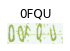

In [31]:
ds.show(ds[0])

In [32]:
x, y = ds[0]

In [33]:
x, y

(PILImage mode=RGB size=160x60, TensorCategory([2, 2, 3, 4, 5]))

In [34]:
dl = ds.dataloaders(
    bs=8,
    before_batch=BeforeBatchTransform(keep_ratio=True),
    create_batch=CreateBatchTransform(),
    after_batch=[
        IntToFloatTensor(), 
        Normalize.from_stats([0.5] * 3, [0.5] * 3),
    ]
)

In [35]:
x, y = dl.one_batch()

In [36]:
x.size()

torch.Size([8, 3, 32, 160])

In [37]:
y[0], y[1]

(TensorCategory([26, 39, 38, 25, 40, 43, 60, 32, 15,  6,  2, 30,  7, 61, 32, 39, 15,  5,
         14,  7, 44, 60, 29, 41, 48, 14, 21,  7,  3, 39, 38, 25, 38, 14, 26, 21,
          3, 19, 30, 30], device='cuda:0'),
 TensorCategory([5, 5, 5, 5, 5, 5, 5, 5], device='cuda:0'))

In [38]:
test_dl = dl.test_dl([Path('2b827.png')], with_labels=False)

In [39]:
test_dl.one_batch()

(TensorImage([[[[0.5059, 0.5059, 0.5137,  ..., 0.9608, 0.9686, 0.9686],
           [0.5059, 0.5059, 0.5137,  ..., 0.9608, 0.9686, 0.9686],
           [0.5059, 0.5059, 0.5137,  ..., 0.9608, 0.9686, 0.9686],
           ...,
           [0.5216, 0.5216, 0.5294,  ..., 0.9765, 0.9843, 0.9843],
           [0.5294, 0.5294, 0.5373,  ..., 0.9843, 0.9922, 0.9922],
           [0.5294, 0.5294, 0.5373,  ..., 0.9843, 0.9922, 0.9922]],
 
          [[0.5059, 0.5059, 0.5137,  ..., 0.9608, 0.9686, 0.9686],
           [0.5059, 0.5059, 0.5137,  ..., 0.9608, 0.9686, 0.9686],
           [0.5059, 0.5059, 0.5137,  ..., 0.9608, 0.9686, 0.9686],
           ...,
           [0.5216, 0.5216, 0.5294,  ..., 0.9765, 0.9843, 0.9843],
           [0.5294, 0.5294, 0.5373,  ..., 0.9843, 0.9922, 0.9922],
           [0.5294, 0.5294, 0.5373,  ..., 0.9843, 0.9922, 0.9922]],
 
          [[0.5059, 0.5059, 0.5137,  ..., 0.9608, 0.9686, 0.9686],
           [0.5059, 0.5059, 0.5137,  ..., 0.9608, 0.9686, 0.9686],
           [0.5059,

# Model

## CNN model

In [40]:
def conv_block(in_c, out_c, ks, stride, p, bn=False, leaky_relu=False):
    layers = list()
    layers.append(nn.Conv2d(
        in_channels=in_c,
        out_channels=out_c,
        kernel_size=ks,
        stride=stride,
        padding=p,
    ))

    if bn:
        layers.append(nn.BatchNorm2d(num_features=out_c))

    if leaky_relu:
        layers.append(nn.LeakyReLU(0.2, True))
    else:
        layers.append(nn.ReLU())
    return layers

class CNN(nn.Module):
    def __init__(self, in_channels=3):
        super(CNN, self).__init__()
        ks = [3, 3, 3, 3, 3, 3, 2]
        s  = [1, 1, 1, 1, 1, 1, 1]
        p  = [1, 1, 1, 1, 1, 1, 0]
        c  = [64, 128, 256, 256, 512, 512, 512]
        mp = [(2, 2), (2, 2), None, ((1, 2), 2), None, ((1, 2), 2), None]
        bn = [False, False, False, False, True, True, False]

        layers = []
        for i in range(len(ks)):
            in_c = in_channels if i == 0 else c[i - 1]
            layers.extend(conv_block(in_c=in_c, out_c=c[i], ks=ks[i], stride=s[i], p=p[i], bn=bn[i]))
            if mp[i] is not None:
                kernel_size, stride = mp[i]
                layers.append(nn.MaxPool2d(kernel_size=kernel_size, stride=stride))

        self.cnn = nn.Sequential(*layers)

    def forward(self, x):
        out = self.cnn(x)
        return out

## RNN model

In [41]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, batch_first=False, bidirectional=True):
        super(RNN, self).__init__()
        self.input_size, self.hidden_size, self.output_size = input_size, hidden_size, output_size
        self.batch_first, self.bidirectional = batch_first, bidirectional

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            bidirectional=bidirectional,
            batch_first=batch_first,
        )

        self.h2o = nn.Linear(in_features=hidden_size * 2 if bidirectional else hidden_size, out_features=output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.h2o(out)

## CRNN model = CNN + RNN

In [42]:
class CRNN(nn.Module):
    def __init__(self, in_channels, rnn_hidden_size, n_classes):
        super(CRNN, self).__init__()
        self.cnn = CNN(in_channels=in_channels)
        self.rnn = nn.Sequential(
            RNN(
                input_size=512,
                hidden_size=rnn_hidden_size,
                output_size=rnn_hidden_size,
                batch_first=False,
                bidirectional=True
            ),
            RNN(
                input_size=rnn_hidden_size,
                hidden_size=rnn_hidden_size,
                output_size=n_classes,
                batch_first=False,
                bidirectional=True
            ),
        )

    def forward(self, x):
        cnn_out = self.cnn(x)
        cnn_out = cnn_out.squeeze(2).permute(2, 0, 1)
        rnn_out = self.rnn(cnn_out)
        return rnn_out

## CTC Loss

In [43]:
class CTCLoss(nn.Module):
    def __init__(self, blank=0):
        super(CTCLoss, self).__init__()
        self.ctc_loss = nn.CTCLoss(blank=blank, zero_infinity=True)

    def forward(self, output, target):
        T, N, C = output.size()
        target, target_lengths = target
        output_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long, device=output.device)
        output = output.log_softmax(2)
        return self.ctc_loss(output, target, output_lengths, target_lengths)

## Accuracy metric

In [44]:
class AccMetric(Metric):
    def __init__(self):
        self.y_true, self.y_pred = [], []

    def reset(self):
        self.y_true, self.y_pred = [], []

    def accumulate(self, learn):
        label_categorize = learn.dls.tfms[1][-1]
        yb_pred = learn.pred.permute(1, 0, 2).argmax(dim=2)
        (yb, y_lengths), = learn.yb

        yb = torch.split(yb, y_lengths.cpu().tolist())
        self.y_true.extend([label_categorize.decode(y, raw=True) for y in yb])

        self.y_pred.extend([label_categorize.decode(y) for y in yb_pred])

    @property
    def value(self):
#         print(self.y_pred[:4], self.y_true[:4])
        n_correct = (np.array(self.y_pred) == np.array(self.y_true)).sum()
        return n_correct / float(len(self.y_true))

    @property
    def name(self):
        return 'accuracy'


### Test model and loss func

In [45]:
model = CRNN(in_channels=3, rnn_hidden_size=256, n_classes=ds.tfms[1][-1].n_classes)
model = model.cuda()

In [46]:
out = model(x)
out.size()

torch.Size([9, 8, 64])

In [47]:
loss_func = CTCLoss(blank=ds.tfms[1][-1].blank_idx)

In [48]:
loss_func(out, y)

tensor(6.1502, device='cuda:0', grad_fn=<MeanBackward0>)

# Train model

## Config

In [50]:
data_path = Path('data/images')
# data_path = Path('data/kaggle_data/samples')
bs = 32

## Load data

In [51]:
f_names = get_image_files(data_path)
# f_names = f_names[:500]

<AxesSubplot:title={'center':'0FQU'}>

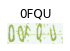

In [52]:
item_tfms = [PILImage.create, ]
y_tfms = [label_func, CategorizeList(add_na=False),]

ds = Datasets(
    items=f_names,
    tfms=[
        item_tfms,
        y_tfms,
    ],
    splits=RandomSplitter(valid_pct=0.2, seed=42)(f_names),
)
ds.show(ds[0])

In [53]:
dls = ds.dataloaders(
    bs=bs,
    before_batch=BeforeBatchTransform(keep_ratio=True),
    create_batch=CreateBatchTransform(),
    after_batch=[IntToFloatTensor, Normalize.from_stats([0.5] * 3, [0.5] * 3)],
)

In [54]:
# dls.one_batch()

## Create model

In [55]:
model = CRNN(in_channels=3, rnn_hidden_size=256, n_classes=ds.tfms[1][-1].n_classes)
loss_func = CTCLoss(blank=ds.tfms[1][-1].blank_idx)

In [56]:
ds.tfms[1][-1].vocab

(#63) ['-','V','A','R','I','J','U','1','d','x'...]

## Create learner

In [57]:
learner = Learner(
    dls=dls,
    model=model,
    loss_func=loss_func,
    metrics=[AccMetric()]
)

## Training

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.0002754228771664202)

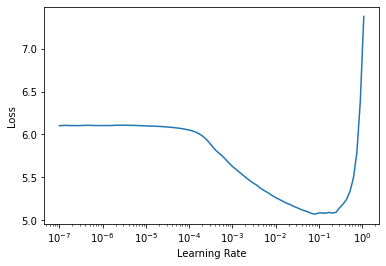

In [58]:
# learning rate finder
learner.lr_find()

In [59]:
# fit one cycle
learner.fit_one_cycle(30, lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.450558,4.300001,0.000000,00:13
1,4.313459,4.303929,0.000000,00:13
2,4.276678,4.291604,0.000000,00:12
3,4.218538,4.246852,0.000000,00:12
4,4.077287,4.105125,0.000000,00:12
5,4.024330,4.052740,0.000000,00:13
6,3.953100,4.210034,0.000000,00:12
7,3.802382,3.835923,0.000000,00:12
8,3.662026,3.703047,0.000000,00:12
9,3.512480,3.529841,0.000000,00:13


In [198]:
learner.save('captcha_9393')

Path('models/captcha_9393.pth')

In [199]:
learner.export('captcha_9393.pkl')

## Predict


### Load learner

In [13]:
learner = load_learner('captcha_9393.pkl')

### Load test_dl

In [14]:
# test_files = L(Path('2b827.png'))
test_files = L(Path('98348.png'))

In [15]:
test_dl = learner.dls.test_dl(test_files)

In [16]:
test_dl.one_batch()[0].size()

torch.Size([1, 3, 32, 104])

### Get predictions

In [17]:
preds = learner.get_preds(dl=test_dl, reorder=False)[0]
preds.size()

/home/thanhlt998/anaconda3/envs/deep-learning/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


torch.Size([5, 1, 20])

### Get prediction text

In [18]:
[learner.dls.tfms[-1][-1].decode(preds[:,i,:].argmax(dim=-1)) for i in range(preds.size(1))]

['xcc']

### Test with transparent background image

In [19]:
tmp = PILImageBW.create('98348.png')

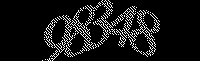

In [25]:
tmp.convert('1')

In [28]:
test_dl = learner.dls.test_dl(['98348.png'])
x = test_dl.one_batch()[0]

In [37]:
x = torch.where(x != -1, x, torch.full(size=x.size(), fill_value=1, dtype=x.dtype))
preds = learner.model(x)

In [38]:
[learner.dls.tfms[-1][-1].decode(preds[:,i,:].argmax(dim=-1)) for i in range(preds.size(1))]

['g6']

In [40]:
preds.size(), x.size()


(torch.Size([5, 1, 20]), torch.Size([1, 3, 32, 104]))